## Confusion Matrices Building

In [22]:
# System imports
import random, os

# Core imports
import tensorflow as tf
import numpy as np
import cv2

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from skimage.io import imread_collection

# Display imports
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

# Helper imports
from imutils import paths
import pickle
import shutil
import itertools
from itertools import cycle

def tf_seed(seed=0):
    np.random.seed(seed)  # numpy seed
    tf.random.set_seed(seed)  # tensorflow seed
    random.seed(seed)  # random seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

# Loading models

In [23]:
models = {
    "msspoof": tf.keras.models.load_model("./models/model_MSSpoof.h5"),
    "3dmad": tf.keras.models.load_model("./models/model_3DMAD.h5"),
    "csmad": tf.keras.models.load_model("./models/model_CSMAD.h5"),
    "replay_attack": tf.keras.models.load_model("./models/model_Replay_Attack.h5"),
    'our': tf.keras.models.load_model("./models/first_task_model.h5")
}

def get_model(name: str):
    return models[name]

# Dataset preprocessing

In [6]:
import loader_msspoof
import loader_3dmad
import loader_csmad

In [24]:
def load_csmad(_bonifade, _attack):
    root_folder = './datasets/CSMAD/CSMAD'
    output_np_training_array = os.path.join(root_folder, 'CSMAD_training_array')
    (_, test_X, _, test_Y) = pickle.loads(open(output_np_training_array, "rb").read())
    test_X = test_X[..., :3]
    return test_X, test_Y, 0

def load_replay_attack(_bonifade, _attack):
    root_folder = './datasets/Replay_Attack/Replay_Attack'
    output_np_training_array = os.path.join(root_folder, 'Replay_Attack_training_array')
    (_, test_X, _, test_Y) = pickle.loads(open(output_np_training_array, "rb").read())
    return test_X, test_Y, 0

def load_our(_bonifade, _attack):
    root_folder = './datasets/Our'
    output_np_training_array = os.path.join(root_folder, 'training.array')
    (_, test_X, _, test_Y, final_test_X, final_test_Y) = pickle.loads(open(output_np_training_array, "rb").read())
    return test_X, test_Y, 0

base_pathes = {
    'msspoof': './datasets/MSSpoof/MSSpoof_dataset/images',
    '3dmad': './datasets/3DMAD/3DMAD/images',
    'csmad': './datasets/CSMAD/CSMAD/images',
    'replay_attack': './datasets/',
    'our': './datasets/Our'
}

load_fns = {
    'msspoof': lambda bonifade, attack: loader_msspoof.get_images([bonifade, attack], undersampling=True),
    '3dmad': lambda bonifade, attack: loader_3dmad.get_images([bonifade, attack], undersampling=True, mask=False),
    'csmad': load_csmad,
    'replay_attack': load_replay_attack,
    'our': load_our
}

In [25]:
def load_dataset(name: str):
    bonifade = f'{base_pathes[name]}/bonifade_validation'
    attack = f'{base_pathes[name]}/attack_validation'
    
    X, Y, _ = load_fns[name](bonifade, attack)
    Y = np.argmax(Y, axis=1)
    return X, Y

In [26]:
def test_model_dataset(model, dataset):
    (X, Y) = dataset
    predictions = model.predict(X[:4], verbose=0)
    plt.figure(figsize=(6,6)) # specifying the overall grid size

    for i in range(len(predictions)):
        plt.subplot(2, 2, i+1)
        plt.imshow(X[i])
        print(f'Label #{i}:', 'Real' if Y[i] == 0 else 'Fake')
        print(f'Prediction #{i}:', 'Real' if predictions[i][0] > predictions[i][1] else 'Fake')

    plt.show()

# Confusion matrix displaying

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    def precision(index):
        return round(cm[index][index] / cm[:, index].sum(),2)

    def recall(index):
        return round(cm[index][index] /cm[index].sum(),2)

    def F1_score(index):
        p=precision(index)
        r=recall(index)
        return round((2 * p * r)/(p + r),2)

    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



    #### CREATE THE PRECISION / RECALL / F1_SCORE TABLE ####

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig, ax1 = plt.subplots(figsize=(10, 2 + 3 / 2.5))

    col_labels=["Bonafide", "Attacker"]
    row_labels=['Precision','Recall','F1 Score']
    row_func=[precision,recall,F1_score]
    table_vals=[]

    row_colors = np.full(len(row_labels), 'linen')
    col_colors = np.full(len(col_labels), 'lavender')


    for i in range(0, len(row_labels)):
        row=[]

        for j in range(0, len(col_labels)):
            row.append(row_func[i](j))

        table_vals.append(row)


    # the rectangle is where I want to place the table
    table = plt.table(cellText=table_vals,
                  cellLoc='center',
                  rowColours=row_colors,
                  rowLabels=row_labels,
                  rowLoc='center',
                  colColours=col_colors,
                  colLabels=col_labels,
                  loc='center')
    table.scale(1, 2)
    ax1.axis('off')

class_names = {"Bonafide", "Attacker"}

# Prining confusion matrices!

--- Model msspoof on dataset msspoof ---
--- Model msspoof on dataset 3dmad ---
--- Model msspoof on dataset csmad ---
--- Model msspoof on dataset replay_attack ---
--- Model msspoof on dataset our ---
--- Model 3dmad on dataset msspoof ---
--- Model 3dmad on dataset 3dmad ---
--- Model 3dmad on dataset csmad ---
--- Model 3dmad on dataset replay_attack ---
--- Model 3dmad on dataset our ---
--- Model csmad on dataset msspoof ---


/tmp/ipykernel_44866/2651661900.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6), dpi=80)


--- Model csmad on dataset 3dmad ---
--- Model csmad on dataset csmad ---
--- Model csmad on dataset replay_attack ---
--- Model csmad on dataset our ---
--- Model replay_attack on dataset msspoof ---
--- Model replay_attack on dataset 3dmad ---
--- Model replay_attack on dataset csmad ---
--- Model replay_attack on dataset replay_attack ---
--- Model replay_attack on dataset our ---
--- Model our on dataset msspoof ---
--- Model our on dataset 3dmad ---
--- Model our on dataset csmad ---
--- Model our on dataset replay_attack ---
--- Model our on dataset our ---


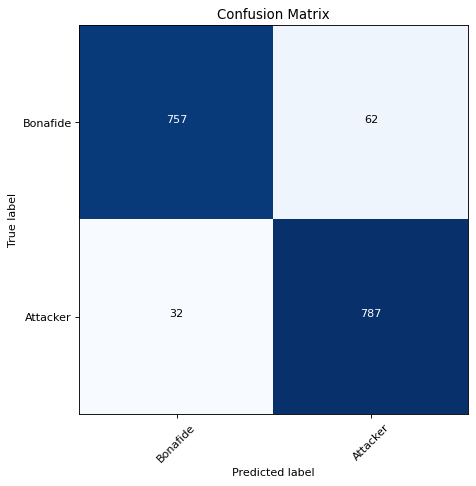

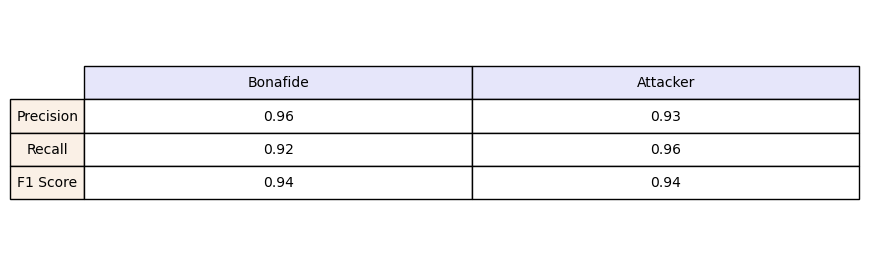

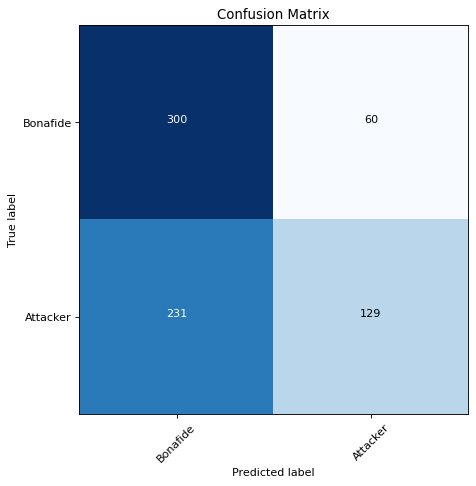

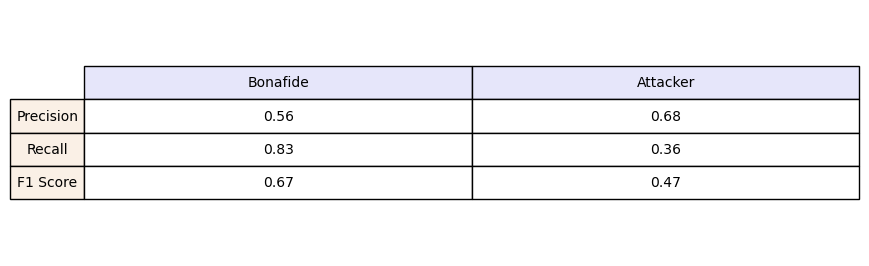

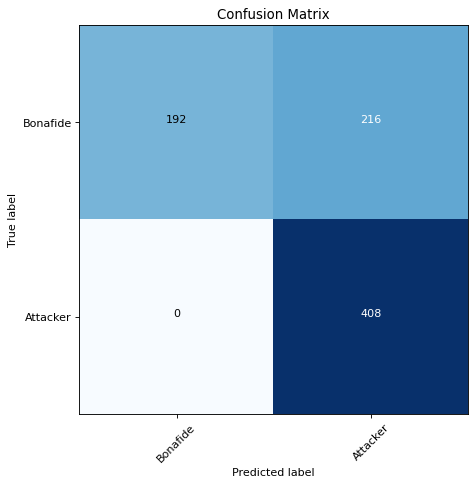

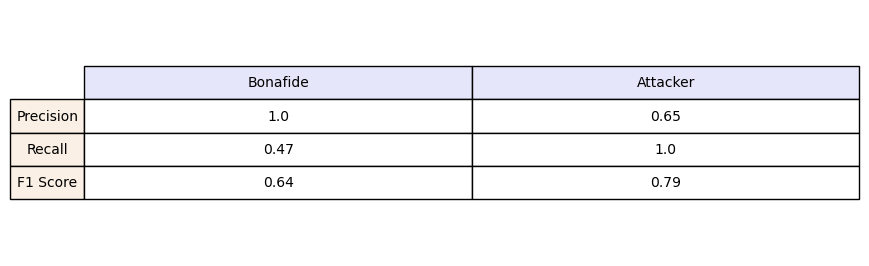

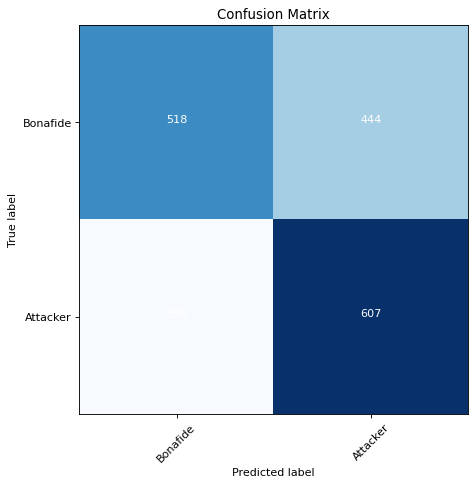

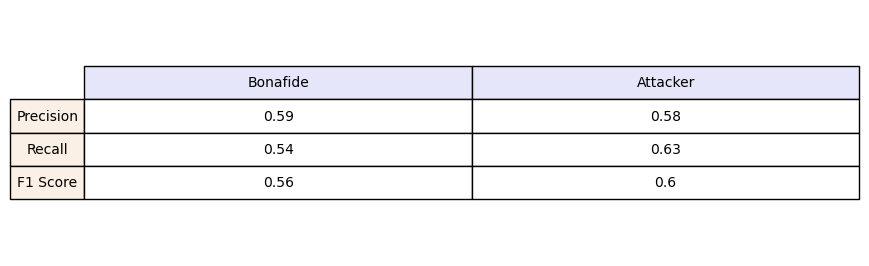

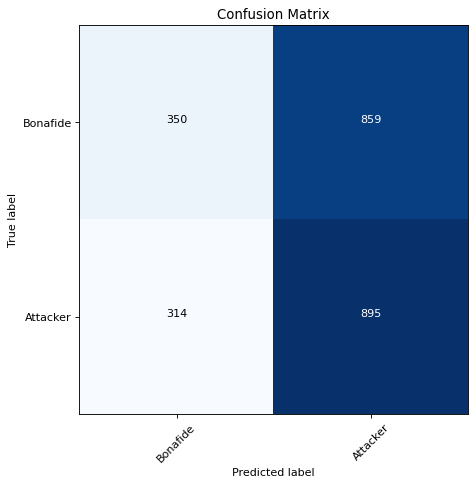

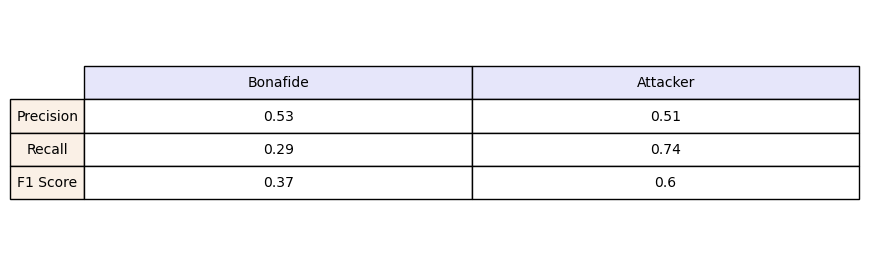

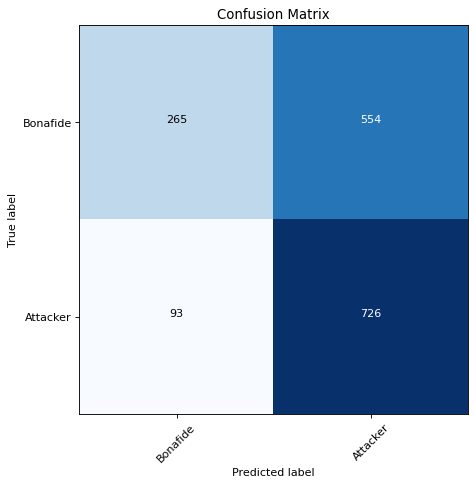

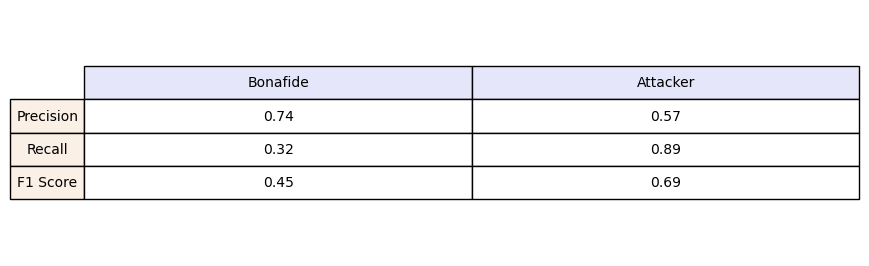

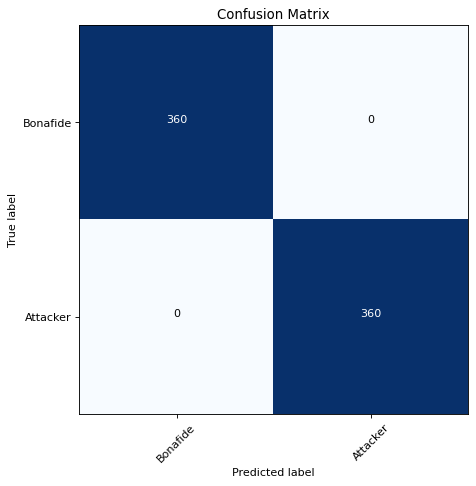

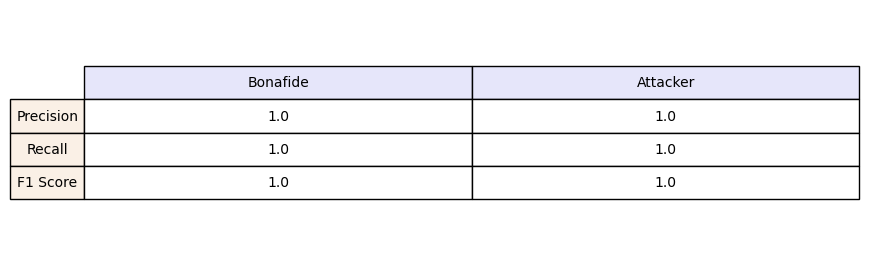

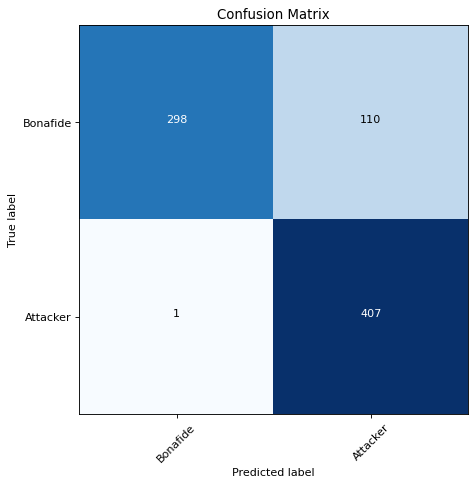

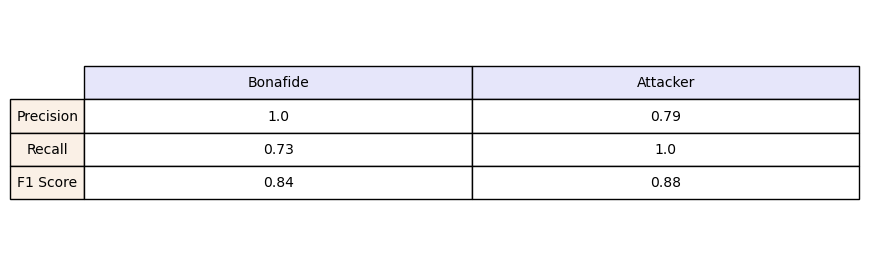

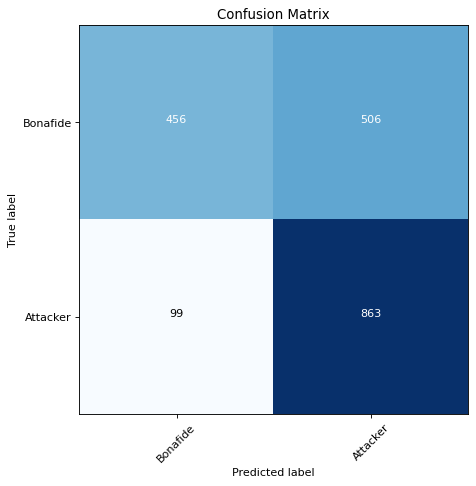

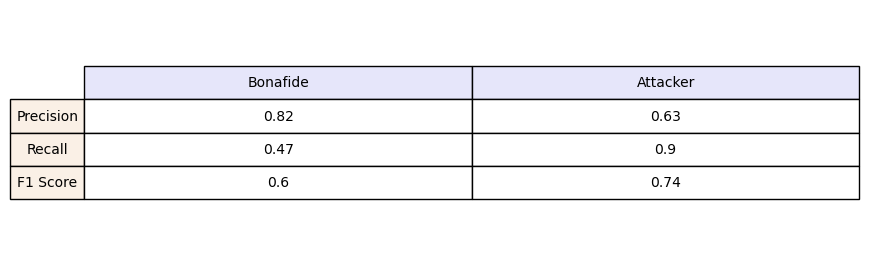

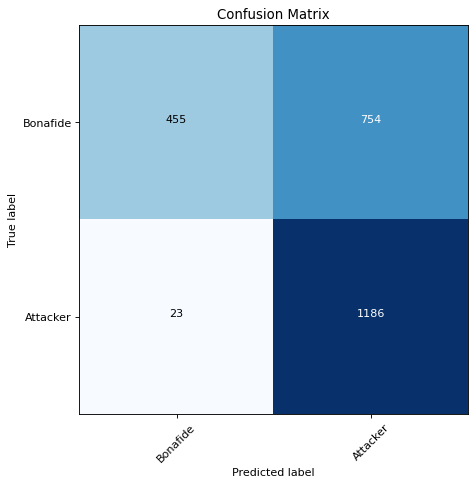

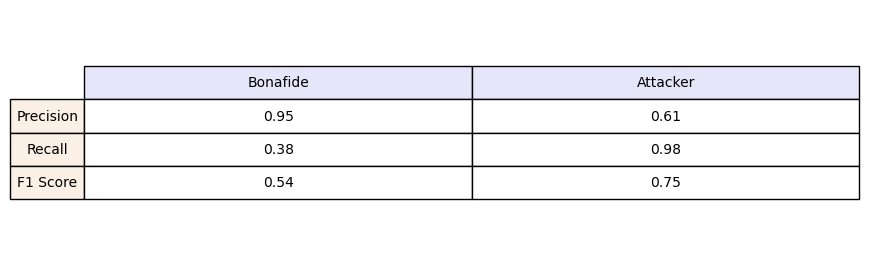

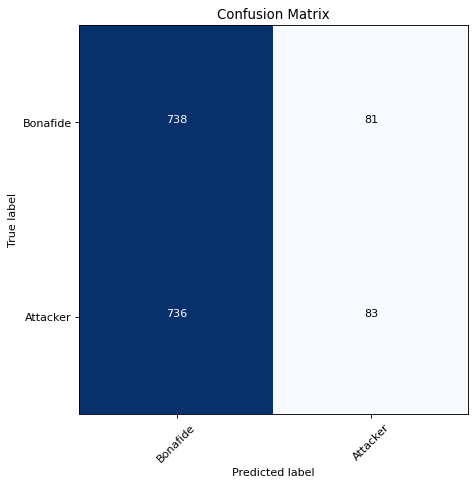

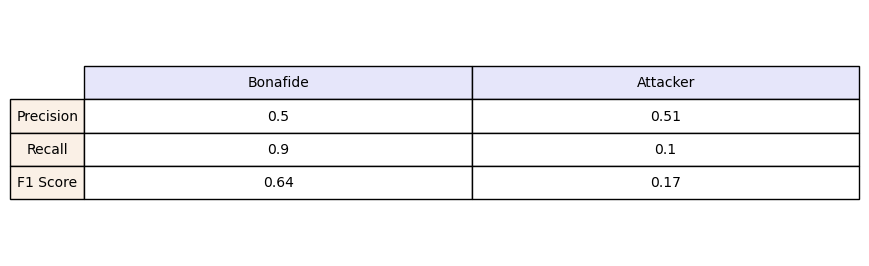

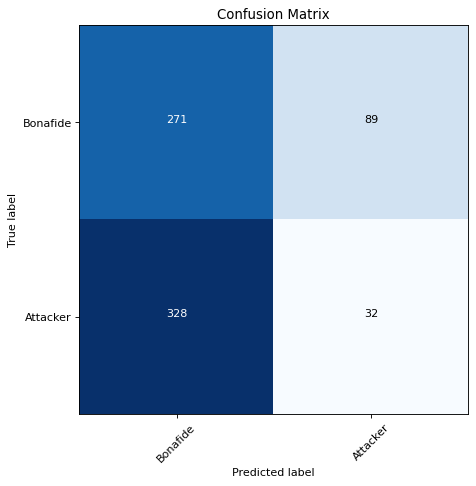

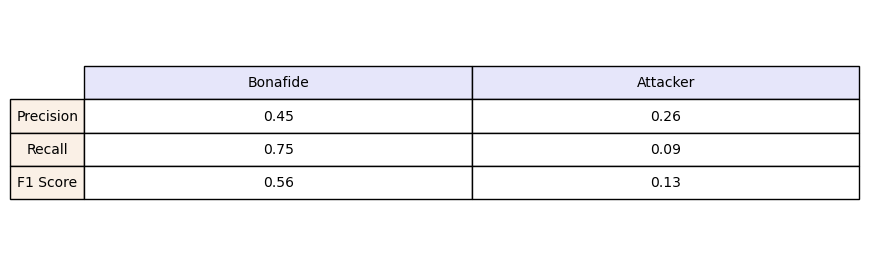

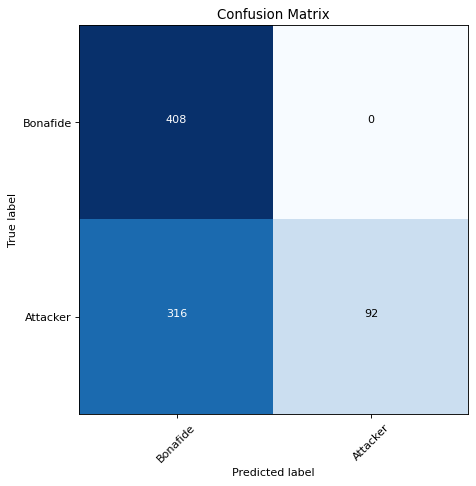

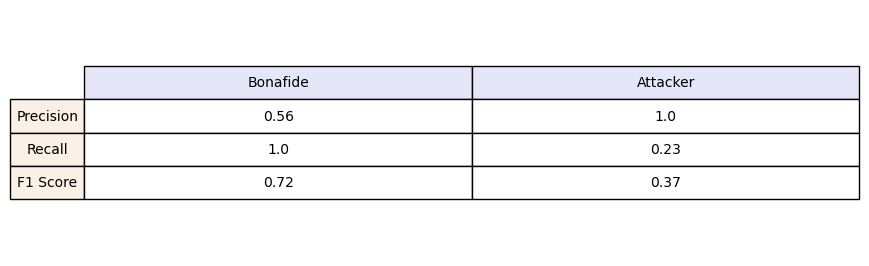

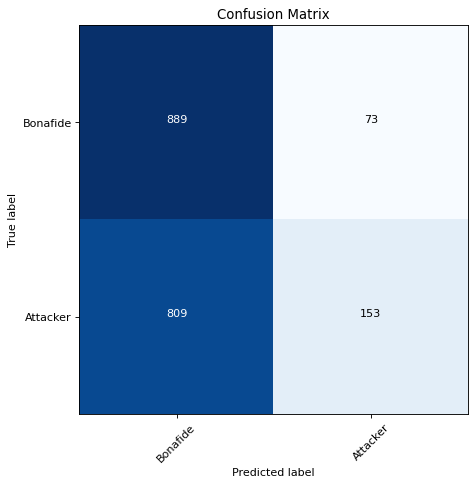

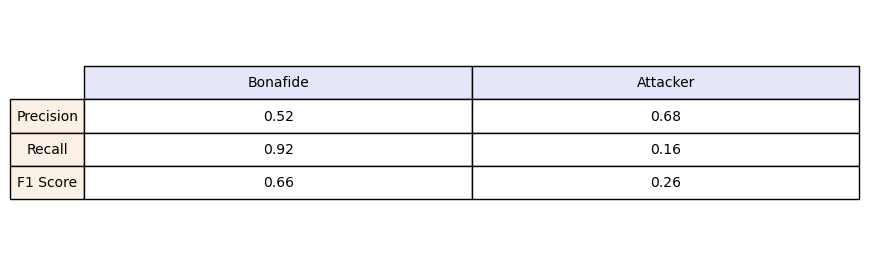

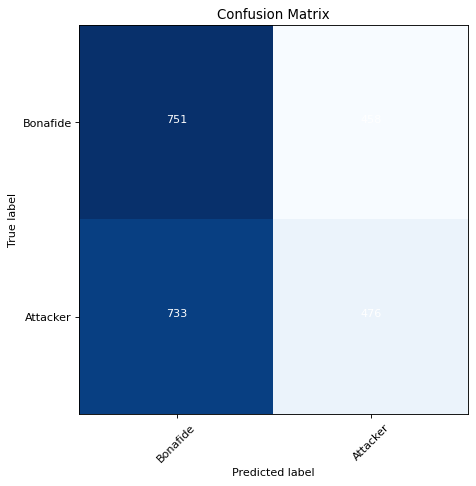

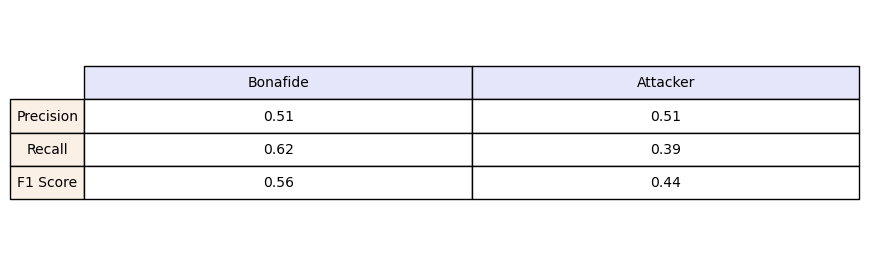

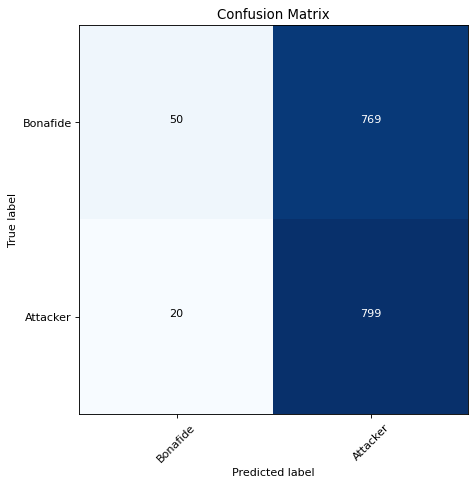

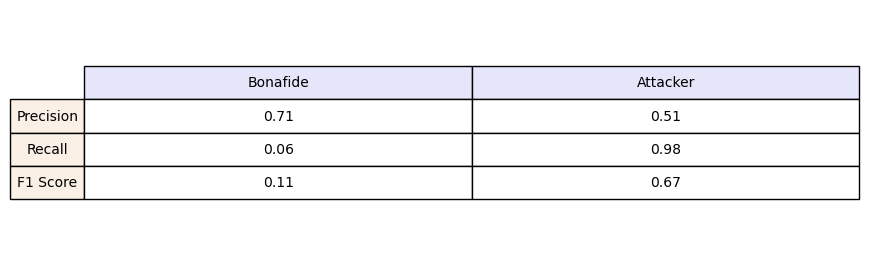

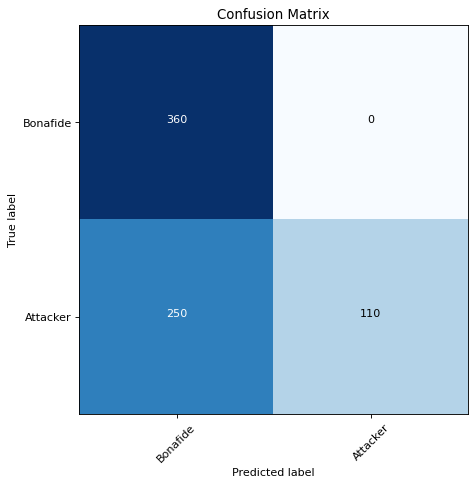

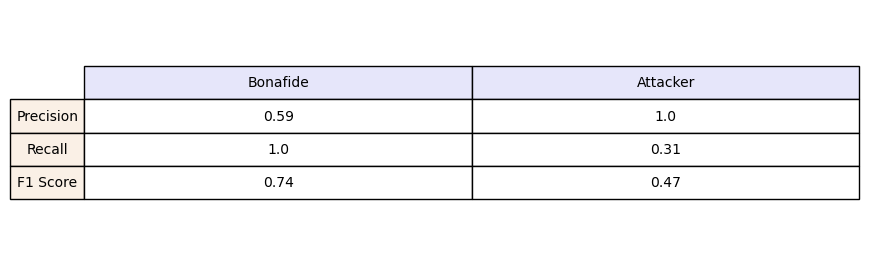

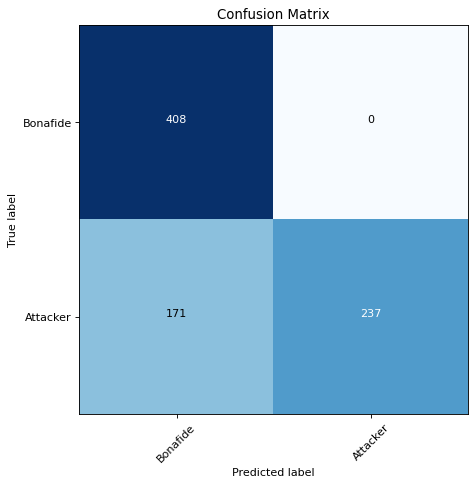

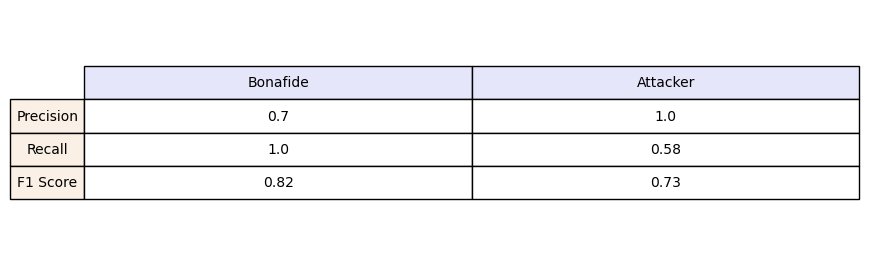

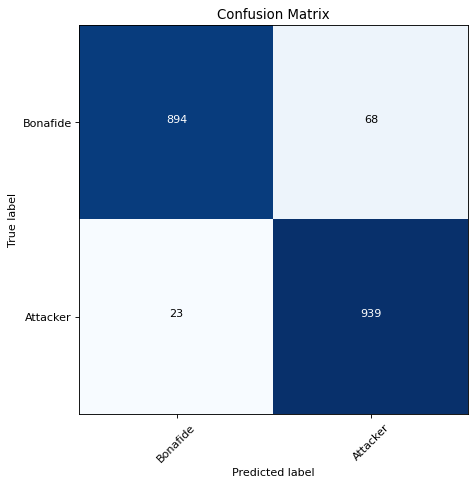

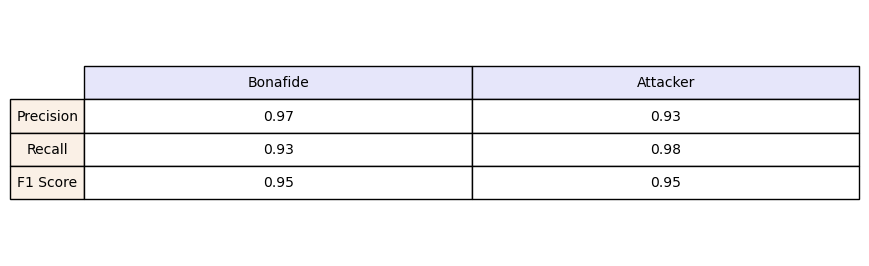

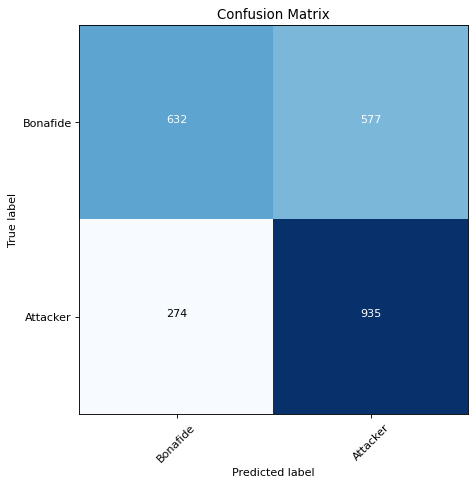

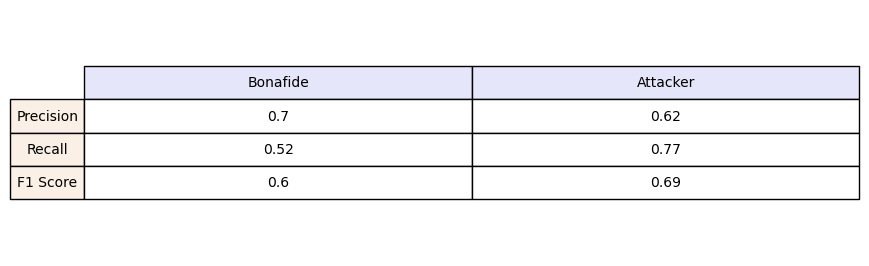

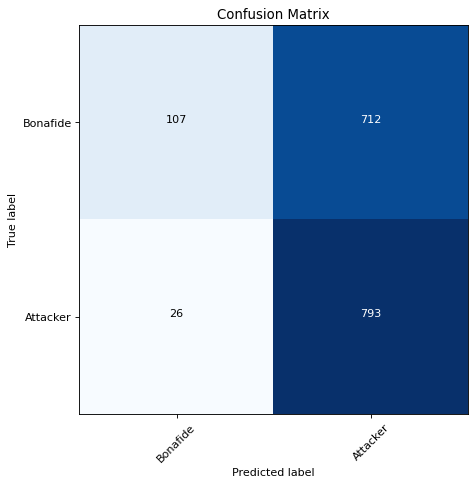

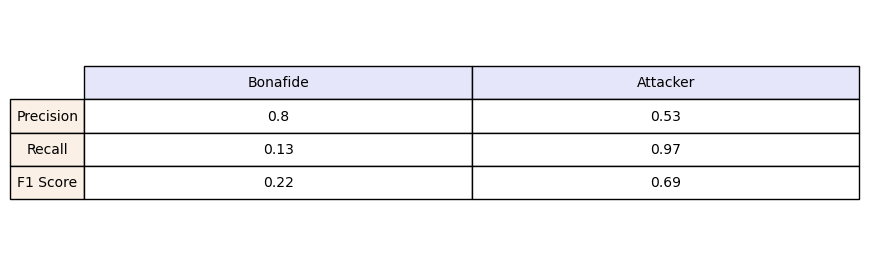

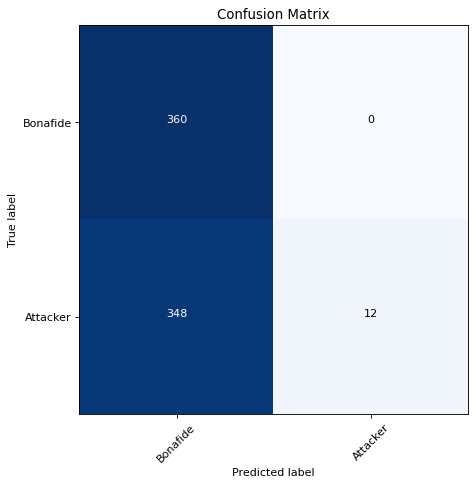

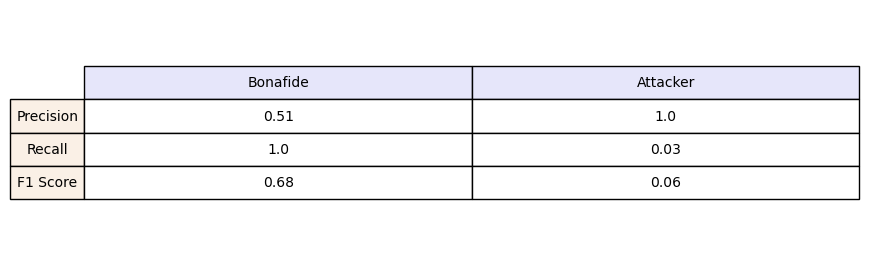

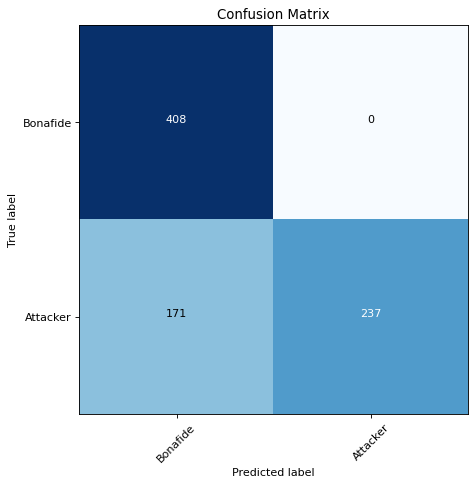

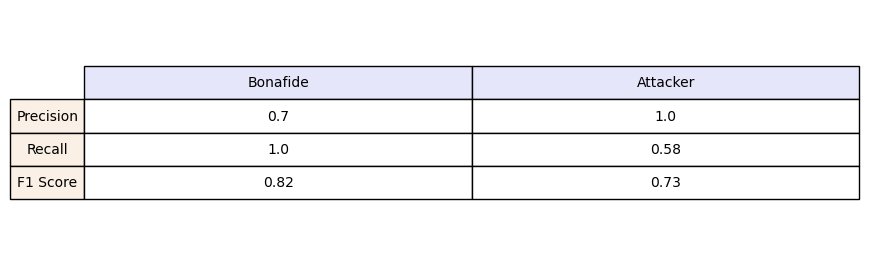

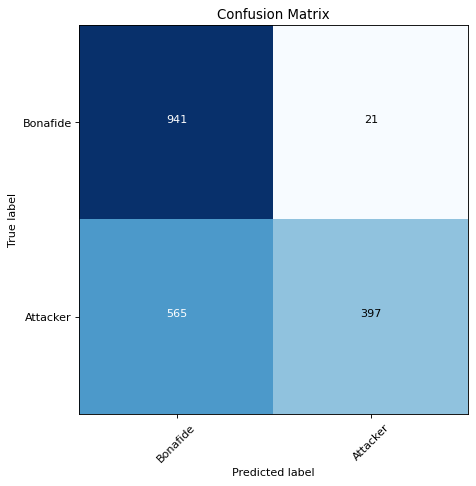

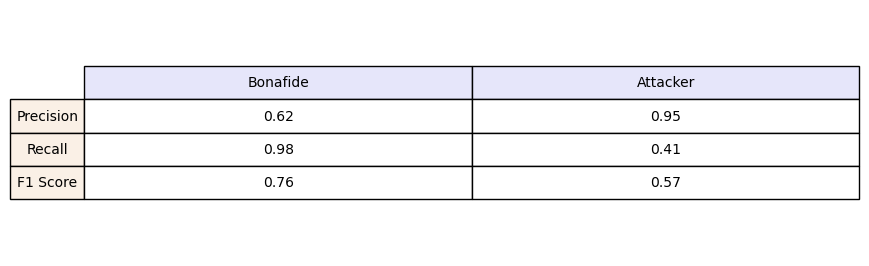

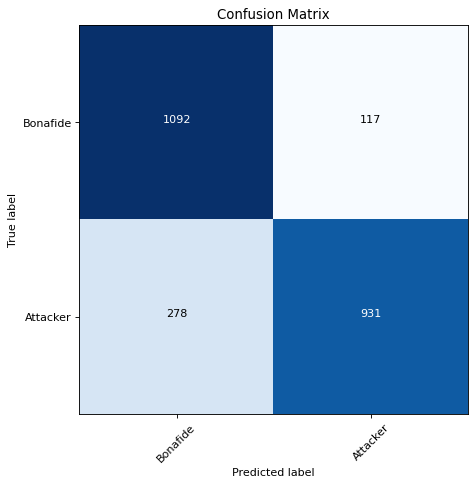

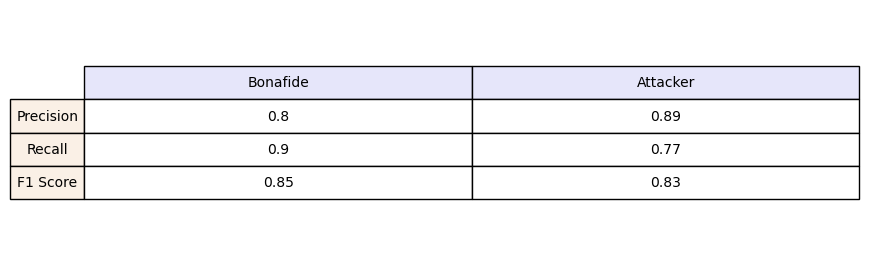

In [28]:
names = ['msspoof', '3dmad', 'csmad', 'replay_attack', 'our']

for model_name in names:
    for dataset_name in names:
        model = get_model(model_name)
        X, Y = load_dataset(dataset_name)
        
        # one might uncomment the line below for the debugging purposes
        # test_model_dataset(model, (X, Y))
        
        Y_score = model.predict(X, verbose=0)
        Y_prediction = np.argmax(Y_score, axis=1)
        
        # Compute confusion matrix
        print(f'--- Model {model_name} on dataset {dataset_name} ---')
        cnf_matrix = confusion_matrix(Y, Y_prediction)

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title='Confusion Matrix')